# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
from collections import Counter
## Your code here
t = 1e-5
total_words = len(int_words)
word_count = Counter(int_words)
train_words = [word for word in int_words if np.random.random() < (1 - np.sqrt(t * total_words / word_count[word]))]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    
    return list(set(words[max(idx-R, 0): idx+R]))

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, (None), name='inputs')
    # labels is required to have a shape of (batch_size, num_true) by tf.nn.sampled_softmax_loss
    labels = tf.placeholder(tf.int32, (None, None), name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1)) # create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(weights=softmax_w, biases=softmax_b, 
                                      labels=labels, inputs=embed,
                                      num_sampled=n_sampled, num_classes=n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
import random
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 8.6906 0.2504 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 7.3948 0.2456 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 6.1466 0.2472 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.3710 0.2461 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.0132 0.2466 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 4.6927 0.2471 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 4.4623 0.2458 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 4.3049 0.2454 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 4.3873 0.2486 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 4.3157 0.2481 sec/batch
Nearest to has: example, women, dutch, early, linnean, of, pasteur, placed,
Nearest to no: xj, town, hydraulics, county, allows, lockwood, germany, referred,
Nearest to d: inner, cities, itself, rights, highly, kangaroo, purpose, die,
Nearest to a: metrolink, wrote, take, design, produced, low, pri

Epoch 1/10 Iteration: 4100 Avg. Training loss: 3.9321 0.2364 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 3.9281 0.2320 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 3.9594 0.2315 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 3.9525 0.2317 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 3.9157 0.2299 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 3.9021 0.2315 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 3.8804 0.2301 sec/batch
Epoch 1/10 Iteration: 4800 Avg. Training loss: 3.9137 0.2310 sec/batch
Epoch 1/10 Iteration: 4900 Avg. Training loss: 3.9164 0.2346 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 3.8964 0.2345 sec/batch
Nearest to has: been, example, dutch, pasteur, linnean, member, women, famously,
Nearest to no: xj, repeated, transformation, legs, just, button, allows, soul,
Nearest to d: f, poet, o, crucial, lucy, basketball, kangaroo, exists,
Nearest to a: noise, justification, metrolink, man, wrote, 

Epoch 1/10 Iteration: 8100 Avg. Training loss: 3.8803 0.2343 sec/batch
Epoch 1/10 Iteration: 8200 Avg. Training loss: 3.8818 0.2320 sec/batch
Epoch 1/10 Iteration: 8300 Avg. Training loss: 3.8737 0.2354 sec/batch
Epoch 1/10 Iteration: 8400 Avg. Training loss: 3.8415 0.2314 sec/batch
Epoch 1/10 Iteration: 8500 Avg. Training loss: 3.8841 0.2304 sec/batch
Epoch 1/10 Iteration: 8600 Avg. Training loss: 3.8905 0.2331 sec/batch
Epoch 1/10 Iteration: 8700 Avg. Training loss: 3.8362 0.2317 sec/batch
Epoch 1/10 Iteration: 8800 Avg. Training loss: 3.8630 0.2328 sec/batch
Epoch 1/10 Iteration: 8900 Avg. Training loss: 3.8749 0.2317 sec/batch
Epoch 1/10 Iteration: 9000 Avg. Training loss: 3.8650 0.2327 sec/batch
Nearest to has: been, pasteur, dutch, linnean, had, example, member, structured,
Nearest to no: xj, longer, there, repeated, just, mussolini, transformation, matter,
Nearest to d: lucy, exists, inner, f, kangaroo, o, drove, solving,
Nearest to a: man, metrolink, remarks, noise, justificati

Epoch 2/10 Iteration: 12100 Avg. Training loss: 3.8726 0.1179 sec/batch
Epoch 2/10 Iteration: 12200 Avg. Training loss: 3.8744 0.2324 sec/batch
Epoch 2/10 Iteration: 12300 Avg. Training loss: 3.8557 0.2319 sec/batch
Epoch 2/10 Iteration: 12400 Avg. Training loss: 3.8845 0.2318 sec/batch
Epoch 2/10 Iteration: 12500 Avg. Training loss: 3.7964 0.2284 sec/batch
Epoch 2/10 Iteration: 12600 Avg. Training loss: 3.8335 0.2285 sec/batch
Epoch 2/10 Iteration: 12700 Avg. Training loss: 3.8019 0.2274 sec/batch
Epoch 2/10 Iteration: 12800 Avg. Training loss: 3.7167 0.2268 sec/batch
Epoch 2/10 Iteration: 12900 Avg. Training loss: 3.7649 0.2273 sec/batch
Epoch 2/10 Iteration: 13000 Avg. Training loss: 3.8411 0.2287 sec/batch
Nearest to has: been, pasteur, linnean, had, structured, recent, dutch, remains,
Nearest to no: xj, longer, there, repeated, matter, legs, thing, doctrines,
Nearest to d: claude, kangaroo, f, playwright, poet, ch, lucy, hans,
Nearest to a: metrolink, remarks, man, noise, wrote, j

Epoch 2/10 Iteration: 16100 Avg. Training loss: 3.8452 0.3958 sec/batch
Epoch 2/10 Iteration: 16200 Avg. Training loss: 3.8345 0.3769 sec/batch
Epoch 2/10 Iteration: 16300 Avg. Training loss: 3.8513 0.3417 sec/batch
Epoch 2/10 Iteration: 16400 Avg. Training loss: 3.8591 0.3416 sec/batch
Epoch 2/10 Iteration: 16500 Avg. Training loss: 3.8220 0.3414 sec/batch
Epoch 2/10 Iteration: 16600 Avg. Training loss: 3.8120 0.3372 sec/batch
Epoch 2/10 Iteration: 16700 Avg. Training loss: 3.7737 0.3349 sec/batch
Epoch 2/10 Iteration: 16800 Avg. Training loss: 3.8414 0.3400 sec/batch
Epoch 2/10 Iteration: 16900 Avg. Training loss: 3.8234 0.3407 sec/batch
Epoch 2/10 Iteration: 17000 Avg. Training loss: 3.7994 0.3407 sec/batch
Nearest to has: been, had, pasteur, linnean, since, recent, dutch, recently,
Nearest to no: longer, there, xj, evidence, repeated, thing, matter, legs,
Nearest to d: kangaroo, f, garfield, ch, lucy, claude, hallows, poet,
Nearest to a: metrolink, remarks, man, wrote, produced, no

Epoch 2/10 Iteration: 20100 Avg. Training loss: 3.8274 0.3507 sec/batch
Epoch 2/10 Iteration: 20200 Avg. Training loss: 3.8379 0.3433 sec/batch
Epoch 2/10 Iteration: 20300 Avg. Training loss: 3.8205 0.3441 sec/batch
Epoch 2/10 Iteration: 20400 Avg. Training loss: 3.8270 0.3441 sec/batch
Epoch 2/10 Iteration: 20500 Avg. Training loss: 3.8067 0.3433 sec/batch
Epoch 2/10 Iteration: 20600 Avg. Training loss: 3.8381 0.3419 sec/batch
Epoch 2/10 Iteration: 20700 Avg. Training loss: 3.7830 0.3415 sec/batch
Epoch 2/10 Iteration: 20800 Avg. Training loss: 3.8256 0.3453 sec/batch
Epoch 2/10 Iteration: 20900 Avg. Training loss: 3.8218 0.3444 sec/batch
Epoch 2/10 Iteration: 21000 Avg. Training loss: 3.8670 0.3476 sec/batch
Nearest to has: been, had, linnean, pasteur, since, recent, recently, dutch,
Nearest to no: longer, there, xj, evidence, repeated, limbaugh, matter, peptide,
Nearest to d: kangaroo, f, ch, solving, lucy, garfield, inner, hallows,
Nearest to a: remarks, metrolink, result, wrote, m

Epoch 2/10 Iteration: 24100 Avg. Training loss: 3.8506 0.3484 sec/batch
Epoch 3/10 Iteration: 24200 Avg. Training loss: 3.8333 0.3615 sec/batch
Epoch 3/10 Iteration: 24300 Avg. Training loss: 3.8192 0.3490 sec/batch
Epoch 3/10 Iteration: 24400 Avg. Training loss: 3.8372 0.3474 sec/batch
Epoch 3/10 Iteration: 24500 Avg. Training loss: 3.7959 0.3403 sec/batch
Epoch 3/10 Iteration: 24600 Avg. Training loss: 3.7967 0.3489 sec/batch
Epoch 3/10 Iteration: 24700 Avg. Training loss: 3.7868 0.3495 sec/batch
Epoch 3/10 Iteration: 24800 Avg. Training loss: 3.7033 0.3473 sec/batch
Epoch 3/10 Iteration: 24900 Avg. Training loss: 3.7159 0.3485 sec/batch
Epoch 3/10 Iteration: 25000 Avg. Training loss: 3.8046 0.3406 sec/batch
Nearest to has: been, since, had, pasteur, linnean, recent, recently, dutch,
Nearest to no: longer, there, xj, evidence, matter, limbaugh, repeated, peptide,
Nearest to d: kangaroo, f, garfield, claude, ch, hallows, rowe, wace,
Nearest to a: metrolink, remarks, denmark, result, w

Epoch 3/10 Iteration: 28100 Avg. Training loss: 3.8351 0.3109 sec/batch
Epoch 3/10 Iteration: 28200 Avg. Training loss: 3.8110 0.3136 sec/batch
Epoch 3/10 Iteration: 28300 Avg. Training loss: 3.8192 0.3658 sec/batch
Epoch 3/10 Iteration: 28400 Avg. Training loss: 3.8271 0.3600 sec/batch
Epoch 3/10 Iteration: 28500 Avg. Training loss: 3.8188 0.3478 sec/batch
Epoch 3/10 Iteration: 28600 Avg. Training loss: 3.7957 0.3417 sec/batch
Epoch 3/10 Iteration: 28700 Avg. Training loss: 3.7911 0.3400 sec/batch
Epoch 3/10 Iteration: 28800 Avg. Training loss: 3.7904 0.3288 sec/batch
Epoch 3/10 Iteration: 28900 Avg. Training loss: 3.8079 0.3382 sec/batch
Epoch 3/10 Iteration: 29000 Avg. Training loss: 3.7985 0.3553 sec/batch
Nearest to has: been, had, since, pasteur, recent, linnean, recently, become,
Nearest to no: longer, there, xj, evidence, matter, limbaugh, peptide, stressed,
Nearest to d: kangaroo, hallows, vall, ch, rowe, enrolled, attacker, wace,
Nearest to a: metrolink, remarks, result, denm

Epoch 3/10 Iteration: 32100 Avg. Training loss: 3.8249 0.3765 sec/batch
Epoch 3/10 Iteration: 32200 Avg. Training loss: 3.8203 0.3661 sec/batch
Epoch 3/10 Iteration: 32300 Avg. Training loss: 3.8319 0.3716 sec/batch
Epoch 3/10 Iteration: 32400 Avg. Training loss: 3.7992 0.4040 sec/batch
Epoch 3/10 Iteration: 32500 Avg. Training loss: 3.7738 0.3929 sec/batch
Epoch 3/10 Iteration: 32600 Avg. Training loss: 3.8282 0.3891 sec/batch
Epoch 3/10 Iteration: 32700 Avg. Training loss: 3.8387 0.3867 sec/batch
Epoch 3/10 Iteration: 32800 Avg. Training loss: 3.7539 0.3939 sec/batch
Epoch 3/10 Iteration: 32900 Avg. Training loss: 3.8035 0.4132 sec/batch
Epoch 3/10 Iteration: 33000 Avg. Training loss: 3.8135 0.3891 sec/batch
Nearest to has: been, had, since, pasteur, linnean, recent, recently, scabbard,
Nearest to no: longer, there, xj, evidence, limbaugh, matter, stressed, peptide,
Nearest to d: kangaroo, vall, hallows, enrolled, attacker, rowe, ch, solving,
Nearest to a: metrolink, result, remarks,

Epoch 3/10 Iteration: 36100 Avg. Training loss: 3.8250 0.5159 sec/batch
Epoch 4/10 Iteration: 36200 Avg. Training loss: 3.8240 0.2580 sec/batch
Epoch 4/10 Iteration: 36300 Avg. Training loss: 3.8228 0.5049 sec/batch
Epoch 4/10 Iteration: 36400 Avg. Training loss: 3.8209 0.5164 sec/batch
Epoch 4/10 Iteration: 36500 Avg. Training loss: 3.8149 0.5020 sec/batch
Epoch 4/10 Iteration: 36600 Avg. Training loss: 3.7572 0.4998 sec/batch
Epoch 4/10 Iteration: 36700 Avg. Training loss: 3.7783 0.5071 sec/batch
Epoch 4/10 Iteration: 36800 Avg. Training loss: 3.7751 0.4925 sec/batch
Epoch 4/10 Iteration: 36900 Avg. Training loss: 3.6844 0.5008 sec/batch
Epoch 4/10 Iteration: 37000 Avg. Training loss: 3.7180 0.5119 sec/batch
Nearest to has: been, had, since, pasteur, linnean, recent, recently, scabbard,
Nearest to no: longer, there, xj, evidence, matter, limbaugh, peptide, stressed,
Nearest to d: kangaroo, vall, garfield, claude, wace, attacker, hallows, outright,
Nearest to a: metrolink, result, mix

Epoch 4/10 Iteration: 40100 Avg. Training loss: 3.8210 0.5157 sec/batch
Epoch 4/10 Iteration: 40200 Avg. Training loss: 3.8066 0.5035 sec/batch
Epoch 4/10 Iteration: 40300 Avg. Training loss: 3.8043 0.4910 sec/batch
Epoch 4/10 Iteration: 40400 Avg. Training loss: 3.8210 0.4981 sec/batch
Epoch 4/10 Iteration: 40500 Avg. Training loss: 3.8142 0.5085 sec/batch
Epoch 4/10 Iteration: 40600 Avg. Training loss: 3.7905 0.5060 sec/batch
Epoch 4/10 Iteration: 40700 Avg. Training loss: 3.7926 0.5105 sec/batch
Epoch 4/10 Iteration: 40800 Avg. Training loss: 3.7489 0.5050 sec/batch
Epoch 4/10 Iteration: 40900 Avg. Training loss: 3.8122 0.5038 sec/batch
Epoch 4/10 Iteration: 41000 Avg. Training loss: 3.8008 0.4936 sec/batch
Nearest to has: been, had, since, pasteur, recent, linnean, recently, scabbard,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, peptide, stressed,
Nearest to d: kangaroo, vall, outright, hallows, attacker, garfield, rowe, enrolled,
Nearest to a: metrolink, result, m

Epoch 4/10 Iteration: 44100 Avg. Training loss: 3.8090 0.5216 sec/batch
Epoch 4/10 Iteration: 44200 Avg. Training loss: 3.8100 0.5203 sec/batch
Epoch 4/10 Iteration: 44300 Avg. Training loss: 3.8080 0.5061 sec/batch
Epoch 4/10 Iteration: 44400 Avg. Training loss: 3.8019 0.5093 sec/batch
Epoch 4/10 Iteration: 44500 Avg. Training loss: 3.7997 0.5158 sec/batch
Epoch 4/10 Iteration: 44600 Avg. Training loss: 3.7673 0.5086 sec/batch
Epoch 4/10 Iteration: 44700 Avg. Training loss: 3.8024 0.5147 sec/batch
Epoch 4/10 Iteration: 44800 Avg. Training loss: 3.7567 0.5137 sec/batch
Epoch 4/10 Iteration: 44900 Avg. Training loss: 3.7983 0.5098 sec/batch
Epoch 4/10 Iteration: 45000 Avg. Training loss: 3.7823 0.5046 sec/batch
Nearest to has: been, had, since, recent, pasteur, linnean, recently, scabbard,
Nearest to no: longer, there, evidence, xj, limbaugh, matter, stressed, chilling,
Nearest to d: kangaroo, vall, outright, hallows, attacker, highly, enrolled, segal,
Nearest to a: metrolink, result, l

Epoch 4/10 Iteration: 48100 Avg. Training loss: 3.8056 0.2400 sec/batch
Epoch 4/10 Iteration: 48200 Avg. Training loss: 3.8278 0.2364 sec/batch
Epoch 5/10 Iteration: 48300 Avg. Training loss: 3.8201 0.2378 sec/batch
Epoch 5/10 Iteration: 48400 Avg. Training loss: 3.8078 0.2357 sec/batch
Epoch 5/10 Iteration: 48500 Avg. Training loss: 3.8118 0.2359 sec/batch
Epoch 5/10 Iteration: 48600 Avg. Training loss: 3.7671 0.2331 sec/batch
Epoch 5/10 Iteration: 48700 Avg. Training loss: 3.7849 0.2368 sec/batch
Epoch 5/10 Iteration: 48800 Avg. Training loss: 3.7497 0.2347 sec/batch
Epoch 5/10 Iteration: 48900 Avg. Training loss: 3.6932 0.2324 sec/batch
Epoch 5/10 Iteration: 49000 Avg. Training loss: 3.6936 0.2331 sec/batch
Nearest to has: been, since, had, recent, pasteur, linnean, recently, scabbard,
Nearest to no: longer, there, xj, evidence, matter, limbaugh, peptide, stressed,
Nearest to d: kangaroo, vall, outright, garfield, arabians, attacker, mayakovsky, wace,
Nearest to a: metrolink, mixtur

Epoch 5/10 Iteration: 52100 Avg. Training loss: 3.7981 0.2345 sec/batch
Epoch 5/10 Iteration: 52200 Avg. Training loss: 3.8128 0.2316 sec/batch
Epoch 5/10 Iteration: 52300 Avg. Training loss: 3.8006 0.2308 sec/batch
Epoch 5/10 Iteration: 52400 Avg. Training loss: 3.7939 0.2300 sec/batch
Epoch 5/10 Iteration: 52500 Avg. Training loss: 3.8077 0.2300 sec/batch
Epoch 5/10 Iteration: 52600 Avg. Training loss: 3.8006 0.2312 sec/batch
Epoch 5/10 Iteration: 52700 Avg. Training loss: 3.7774 0.2288 sec/batch
Epoch 5/10 Iteration: 52800 Avg. Training loss: 3.7701 0.2302 sec/batch
Epoch 5/10 Iteration: 52900 Avg. Training loss: 3.7445 0.2295 sec/batch
Epoch 5/10 Iteration: 53000 Avg. Training loss: 3.7993 0.2311 sec/batch
Nearest to has: been, had, since, pasteur, recent, linnean, recently, scabbard,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, peptide, chilling,
Nearest to d: kangaroo, vall, outright, garfield, highly, hungarians, hallows, attacker,
Nearest to a: metrolink, mixtu

Epoch 5/10 Iteration: 56100 Avg. Training loss: 3.7929 0.2320 sec/batch
Epoch 5/10 Iteration: 56200 Avg. Training loss: 3.8022 0.2301 sec/batch
Epoch 5/10 Iteration: 56300 Avg. Training loss: 3.7921 0.2303 sec/batch
Epoch 5/10 Iteration: 56400 Avg. Training loss: 3.8110 0.2315 sec/batch
Epoch 5/10 Iteration: 56500 Avg. Training loss: 3.7893 0.2310 sec/batch
Epoch 5/10 Iteration: 56600 Avg. Training loss: 3.7631 0.2303 sec/batch
Epoch 5/10 Iteration: 56700 Avg. Training loss: 3.8201 0.2300 sec/batch
Epoch 5/10 Iteration: 56800 Avg. Training loss: 3.8159 0.2306 sec/batch
Epoch 5/10 Iteration: 56900 Avg. Training loss: 3.7433 0.2274 sec/batch
Epoch 5/10 Iteration: 57000 Avg. Training loss: 3.7895 0.2296 sec/batch
Nearest to has: been, had, since, recent, pasteur, recently, linnean, scabbard,
Nearest to no: longer, there, evidence, xj, limbaugh, matter, stressed, chilling,
Nearest to d: kangaroo, vall, outright, segal, highly, geats, harare, seperated,
Nearest to a: metrolink, lot, mixture

Epoch 5/10 Iteration: 60100 Avg. Training loss: 3.7664 0.2314 sec/batch
Epoch 5/10 Iteration: 60200 Avg. Training loss: 3.8318 0.2309 sec/batch
Epoch 6/10 Iteration: 60300 Avg. Training loss: 3.8063 0.1168 sec/batch
Epoch 6/10 Iteration: 60400 Avg. Training loss: 3.8119 0.2312 sec/batch
Epoch 6/10 Iteration: 60500 Avg. Training loss: 3.8040 0.2300 sec/batch
Epoch 6/10 Iteration: 60600 Avg. Training loss: 3.8079 0.2307 sec/batch
Epoch 6/10 Iteration: 60700 Avg. Training loss: 3.7457 0.2285 sec/batch
Epoch 6/10 Iteration: 60800 Avg. Training loss: 3.7784 0.2294 sec/batch
Epoch 6/10 Iteration: 60900 Avg. Training loss: 3.7601 0.2304 sec/batch
Epoch 6/10 Iteration: 61000 Avg. Training loss: 3.6718 0.2275 sec/batch
Nearest to has: been, since, had, recent, recently, pasteur, linnean, scabbard,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, peptide, ever,
Nearest to d: kangaroo, vall, outright, garfield, socialite, mayakovsky, arabians, hallows,
Nearest to a: metrolink, mixtur

Epoch 6/10 Iteration: 64100 Avg. Training loss: 3.7993 0.2352 sec/batch
Epoch 6/10 Iteration: 64200 Avg. Training loss: 3.7986 0.2307 sec/batch
Epoch 6/10 Iteration: 64300 Avg. Training loss: 3.8000 0.2307 sec/batch
Epoch 6/10 Iteration: 64400 Avg. Training loss: 3.7964 0.2303 sec/batch
Epoch 6/10 Iteration: 64500 Avg. Training loss: 3.8088 0.2309 sec/batch
Epoch 6/10 Iteration: 64600 Avg. Training loss: 3.8139 0.2307 sec/batch
Epoch 6/10 Iteration: 64700 Avg. Training loss: 3.7781 0.2307 sec/batch
Epoch 6/10 Iteration: 64800 Avg. Training loss: 3.7820 0.2307 sec/batch
Epoch 6/10 Iteration: 64900 Avg. Training loss: 3.7318 0.2279 sec/batch
Epoch 6/10 Iteration: 65000 Avg. Training loss: 3.8064 0.2297 sec/batch
Nearest to has: been, had, since, recent, recently, pasteur, scabbard, bolland,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, peptide, chilling,
Nearest to d: kangaroo, vall, outright, garfield, highly, hungarians, segal, socialite,
Nearest to a: metrolink, mixtur

Epoch 6/10 Iteration: 68100 Avg. Training loss: 3.7906 0.2327 sec/batch
Epoch 6/10 Iteration: 68200 Avg. Training loss: 3.8046 0.2294 sec/batch
Epoch 6/10 Iteration: 68300 Avg. Training loss: 3.7998 0.2298 sec/batch
Epoch 6/10 Iteration: 68400 Avg. Training loss: 3.7910 0.2328 sec/batch
Epoch 6/10 Iteration: 68500 Avg. Training loss: 3.7966 0.2362 sec/batch
Epoch 6/10 Iteration: 68600 Avg. Training loss: 3.8032 0.2341 sec/batch
Epoch 6/10 Iteration: 68700 Avg. Training loss: 3.7669 0.2291 sec/batch
Epoch 6/10 Iteration: 68800 Avg. Training loss: 3.8129 0.2318 sec/batch
Epoch 6/10 Iteration: 68900 Avg. Training loss: 3.7426 0.2291 sec/batch
Epoch 6/10 Iteration: 69000 Avg. Training loss: 3.8062 0.2848 sec/batch
Nearest to has: been, had, since, recent, pasteur, recently, scabbard, linnean,
Nearest to no: longer, there, evidence, xj, limbaugh, matter, stressed, peptide,
Nearest to d: kangaroo, vall, outright, highly, segal, complains, geats, harare,
Nearest to a: mixture, metrolink, lot,

Epoch 6/10 Iteration: 72100 Avg. Training loss: 3.7252 0.2633 sec/batch
Epoch 6/10 Iteration: 72200 Avg. Training loss: 3.8049 0.2643 sec/batch
Epoch 6/10 Iteration: 72300 Avg. Training loss: 3.8390 0.2667 sec/batch
Epoch 7/10 Iteration: 72400 Avg. Training loss: 3.8200 0.2670 sec/batch
Epoch 7/10 Iteration: 72500 Avg. Training loss: 3.7908 0.2626 sec/batch
Epoch 7/10 Iteration: 72600 Avg. Training loss: 3.8141 0.2682 sec/batch
Epoch 7/10 Iteration: 72700 Avg. Training loss: 3.7559 0.2624 sec/batch
Epoch 7/10 Iteration: 72800 Avg. Training loss: 3.7815 0.2650 sec/batch
Epoch 7/10 Iteration: 72900 Avg. Training loss: 3.7542 0.2620 sec/batch
Epoch 7/10 Iteration: 73000 Avg. Training loss: 3.6967 0.2600 sec/batch
Nearest to has: been, had, since, recent, recently, pasteur, linnean, scabbard,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, peptide, ever,
Nearest to d: kangaroo, garfield, vall, outright, mayakovsky, hungarians, socialite, arabians,
Nearest to a: metrolink, mix

Epoch 7/10 Iteration: 76100 Avg. Training loss: 3.7946 0.2719 sec/batch
Epoch 7/10 Iteration: 76200 Avg. Training loss: 3.8045 0.2669 sec/batch
Epoch 7/10 Iteration: 76300 Avg. Training loss: 3.8092 0.2620 sec/batch
Epoch 7/10 Iteration: 76400 Avg. Training loss: 3.7901 0.2661 sec/batch
Epoch 7/10 Iteration: 76500 Avg. Training loss: 3.7942 0.2681 sec/batch
Epoch 7/10 Iteration: 76600 Avg. Training loss: 3.8063 0.2658 sec/batch
Epoch 7/10 Iteration: 76700 Avg. Training loss: 3.7929 0.2651 sec/batch
Epoch 7/10 Iteration: 76800 Avg. Training loss: 3.7811 0.2656 sec/batch
Epoch 7/10 Iteration: 76900 Avg. Training loss: 3.7649 0.2614 sec/batch
Epoch 7/10 Iteration: 77000 Avg. Training loss: 3.7500 0.2647 sec/batch
Nearest to has: been, had, since, recent, recently, bolland, scabbard, pasteur,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, yes, peptide,
Nearest to d: kangaroo, vall, garfield, outright, mayakovsky, hungarians, highly, segal,
Nearest to a: mixture, metrolink, s

Epoch 7/10 Iteration: 80100 Avg. Training loss: 3.8128 0.2678 sec/batch
Epoch 7/10 Iteration: 80200 Avg. Training loss: 3.7742 0.2646 sec/batch
Epoch 7/10 Iteration: 80300 Avg. Training loss: 3.8100 0.2642 sec/batch
Epoch 7/10 Iteration: 80400 Avg. Training loss: 3.7942 0.2663 sec/batch
Epoch 7/10 Iteration: 80500 Avg. Training loss: 3.8063 0.2660 sec/batch
Epoch 7/10 Iteration: 80600 Avg. Training loss: 3.7821 0.2648 sec/batch
Epoch 7/10 Iteration: 80700 Avg. Training loss: 3.7547 0.2675 sec/batch
Epoch 7/10 Iteration: 80800 Avg. Training loss: 3.8056 0.2643 sec/batch
Epoch 7/10 Iteration: 80900 Avg. Training loss: 3.7974 0.2634 sec/batch
Epoch 7/10 Iteration: 81000 Avg. Training loss: 3.7465 0.2605 sec/batch
Nearest to has: been, had, since, recent, recently, scabbard, bolland, pasteur,
Nearest to no: longer, there, evidence, matter, xj, limbaugh, yes, peptide,
Nearest to d: kangaroo, vall, outright, moldavia, garfield, segal, harmattan, highly,
Nearest to a: mixture, metrolink, lot,

Epoch 7/10 Iteration: 84100 Avg. Training loss: 3.7708 0.2687 sec/batch
Epoch 7/10 Iteration: 84200 Avg. Training loss: 3.7620 0.2638 sec/batch
Epoch 7/10 Iteration: 84300 Avg. Training loss: 3.8090 0.2692 sec/batch
Epoch 8/10 Iteration: 84400 Avg. Training loss: 3.8163 0.1361 sec/batch
Epoch 8/10 Iteration: 84500 Avg. Training loss: 3.8030 0.2641 sec/batch
Epoch 8/10 Iteration: 84600 Avg. Training loss: 3.7971 0.2666 sec/batch
Epoch 8/10 Iteration: 84700 Avg. Training loss: 3.8061 0.2662 sec/batch
Epoch 8/10 Iteration: 84800 Avg. Training loss: 3.7367 0.2621 sec/batch
Epoch 8/10 Iteration: 84900 Avg. Training loss: 3.7637 0.2655 sec/batch
Epoch 8/10 Iteration: 85000 Avg. Training loss: 3.7572 0.2676 sec/batch
Nearest to has: been, since, had, recent, recently, gerrymandering, bolland, fallen,
Nearest to no: longer, there, evidence, matter, xj, limbaugh, yes, peptide,
Nearest to d: kangaroo, garfield, vall, outright, mayakovsky, hungarians, arabians, harare,
Nearest to a: metrolink, mi

Epoch 8/10 Iteration: 88100 Avg. Training loss: 3.8077 0.2737 sec/batch
Epoch 8/10 Iteration: 88200 Avg. Training loss: 3.7960 0.2731 sec/batch
Epoch 8/10 Iteration: 88300 Avg. Training loss: 3.7992 0.2656 sec/batch
Epoch 8/10 Iteration: 88400 Avg. Training loss: 3.8053 0.2813 sec/batch
Epoch 8/10 Iteration: 88500 Avg. Training loss: 3.7856 0.2878 sec/batch
Epoch 8/10 Iteration: 88600 Avg. Training loss: 3.8035 0.2869 sec/batch
Epoch 8/10 Iteration: 88700 Avg. Training loss: 3.8012 0.2780 sec/batch
Epoch 8/10 Iteration: 88800 Avg. Training loss: 3.7631 0.2618 sec/batch
Epoch 8/10 Iteration: 88900 Avg. Training loss: 3.7756 0.2581 sec/batch
Epoch 8/10 Iteration: 89000 Avg. Training loss: 3.7277 0.2576 sec/batch
Nearest to has: been, since, had, recent, recently, led, gained, scabbard,
Nearest to no: longer, there, evidence, matter, xj, yes, limbaugh, peptide,
Nearest to d: kangaroo, garfield, outright, vall, mayakovsky, hungarians, highly, contractors,
Nearest to a: metrolink, single, m

Epoch 8/10 Iteration: 92100 Avg. Training loss: 3.8005 19.8932 sec/batch
Epoch 8/10 Iteration: 92200 Avg. Training loss: 3.7843 0.2379 sec/batch
Epoch 8/10 Iteration: 92300 Avg. Training loss: 3.7919 0.2352 sec/batch
Epoch 8/10 Iteration: 92400 Avg. Training loss: 3.7900 0.2360 sec/batch
Epoch 8/10 Iteration: 92500 Avg. Training loss: 3.7943 0.2329 sec/batch
Epoch 8/10 Iteration: 92600 Avg. Training loss: 3.7948 0.2347 sec/batch
Epoch 8/10 Iteration: 92700 Avg. Training loss: 3.7938 0.2322 sec/batch
Epoch 8/10 Iteration: 92800 Avg. Training loss: 3.7703 0.2314 sec/batch
Epoch 8/10 Iteration: 92900 Avg. Training loss: 3.8017 0.2342 sec/batch
Epoch 8/10 Iteration: 93000 Avg. Training loss: 3.7470 0.2315 sec/batch
Nearest to has: been, had, since, recent, recently, bolland, led, scabbard,
Nearest to no: longer, there, evidence, matter, xj, limbaugh, yes, chilling,
Nearest to d: kangaroo, vall, outright, harmattan, moldavia, garfield, complains, spatiality,
Nearest to a: mixture, metrolink

Epoch 8/10 Iteration: 96100 Avg. Training loss: 3.7630 0.2370 sec/batch
Epoch 8/10 Iteration: 96200 Avg. Training loss: 3.7419 0.2292 sec/batch
Epoch 8/10 Iteration: 96300 Avg. Training loss: 3.7919 0.2341 sec/batch
Epoch 8/10 Iteration: 96400 Avg. Training loss: 3.8198 0.2406 sec/batch
Epoch 9/10 Iteration: 96500 Avg. Training loss: 3.8193 0.2370 sec/batch
Epoch 9/10 Iteration: 96600 Avg. Training loss: 3.7805 0.2312 sec/batch
Epoch 9/10 Iteration: 96700 Avg. Training loss: 3.8091 0.2328 sec/batch
Epoch 9/10 Iteration: 96800 Avg. Training loss: 3.7543 0.2310 sec/batch
Epoch 9/10 Iteration: 96900 Avg. Training loss: 3.7732 0.2305 sec/batch
Epoch 9/10 Iteration: 97000 Avg. Training loss: 3.7590 0.2312 sec/batch
Nearest to has: been, had, since, recently, led, recent, fallen, gained,
Nearest to no: longer, there, evidence, matter, xj, limbaugh, ever, peptide,
Nearest to d: kangaroo, garfield, vall, outright, mayakovsky, contractors, hungarians, harmattan,
Nearest to a: metrolink, mixture

Epoch 9/10 Iteration: 100100 Avg. Training loss: 3.7896 0.2392 sec/batch
Epoch 9/10 Iteration: 100200 Avg. Training loss: 3.7913 0.2426 sec/batch
Epoch 9/10 Iteration: 100300 Avg. Training loss: 3.8050 0.2430 sec/batch
Epoch 9/10 Iteration: 100400 Avg. Training loss: 3.8032 0.2417 sec/batch
Epoch 9/10 Iteration: 100500 Avg. Training loss: 3.7913 0.2421 sec/batch
Epoch 9/10 Iteration: 100600 Avg. Training loss: 3.7723 0.2436 sec/batch
Epoch 9/10 Iteration: 100700 Avg. Training loss: 3.7914 0.2379 sec/batch
Epoch 9/10 Iteration: 100800 Avg. Training loss: 3.7847 0.2306 sec/batch
Epoch 9/10 Iteration: 100900 Avg. Training loss: 3.7745 0.2327 sec/batch
Epoch 9/10 Iteration: 101000 Avg. Training loss: 3.7707 0.2394 sec/batch
Nearest to has: been, had, since, led, fallen, recent, recently, gained,
Nearest to no: longer, there, evidence, matter, xj, yes, limbaugh, peptide,
Nearest to d: kangaroo, garfield, vall, outright, harmattan, hungarians, moldavia, contractors,
Nearest to a: metrolink, 

Epoch 9/10 Iteration: 104100 Avg. Training loss: 3.8011 0.2465 sec/batch
Epoch 9/10 Iteration: 104200 Avg. Training loss: 3.7943 0.2350 sec/batch
Epoch 9/10 Iteration: 104300 Avg. Training loss: 3.7851 0.2336 sec/batch
Epoch 9/10 Iteration: 104400 Avg. Training loss: 3.8017 0.2415 sec/batch
Epoch 9/10 Iteration: 104500 Avg. Training loss: 3.7922 0.2372 sec/batch
Epoch 9/10 Iteration: 104600 Avg. Training loss: 3.7978 0.2420 sec/batch
Epoch 9/10 Iteration: 104700 Avg. Training loss: 3.7904 0.2422 sec/batch
Epoch 9/10 Iteration: 104800 Avg. Training loss: 3.7549 0.2403 sec/batch
Epoch 9/10 Iteration: 104900 Avg. Training loss: 3.8043 0.2420 sec/batch
Epoch 9/10 Iteration: 105000 Avg. Training loss: 3.8101 0.2417 sec/batch
Nearest to has: been, had, since, led, fallen, recent, bolland, recently,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, yes, chilling,
Nearest to d: kangaroo, vall, garfield, moldavia, harmattan, complains, outright, f,
Nearest to a: mixture, metrolink, 

Epoch 9/10 Iteration: 108100 Avg. Training loss: 3.7119 0.2443 sec/batch
Epoch 9/10 Iteration: 108200 Avg. Training loss: 3.7638 0.2398 sec/batch
Epoch 9/10 Iteration: 108300 Avg. Training loss: 3.7723 0.2421 sec/batch
Epoch 9/10 Iteration: 108400 Avg. Training loss: 3.8177 0.2444 sec/batch
Epoch 10/10 Iteration: 108500 Avg. Training loss: 3.8018 0.1228 sec/batch
Epoch 10/10 Iteration: 108600 Avg. Training loss: 3.8045 0.2426 sec/batch
Epoch 10/10 Iteration: 108700 Avg. Training loss: 3.7845 0.2340 sec/batch
Epoch 10/10 Iteration: 108800 Avg. Training loss: 3.8190 0.2357 sec/batch
Epoch 10/10 Iteration: 108900 Avg. Training loss: 3.7323 0.2413 sec/batch
Epoch 10/10 Iteration: 109000 Avg. Training loss: 3.7692 0.2436 sec/batch
Nearest to has: been, since, had, recently, recent, led, gained, fallen,
Nearest to no: longer, there, evidence, xj, matter, limbaugh, peptide, ever,
Nearest to d: kangaroo, garfield, vall, hungarians, mayakovsky, outright, contractors, harmattan,
Nearest to a: me

Epoch 10/10 Iteration: 112100 Avg. Training loss: 3.7438 0.2413 sec/batch
Epoch 10/10 Iteration: 112200 Avg. Training loss: 3.7959 0.2392 sec/batch
Epoch 10/10 Iteration: 112300 Avg. Training loss: 3.7881 0.2446 sec/batch
Epoch 10/10 Iteration: 112400 Avg. Training loss: 3.7854 0.2317 sec/batch
Epoch 10/10 Iteration: 112500 Avg. Training loss: 3.8060 0.2357 sec/batch
Epoch 10/10 Iteration: 112600 Avg. Training loss: 3.7841 0.2431 sec/batch
Epoch 10/10 Iteration: 112700 Avg. Training loss: 3.7984 0.2413 sec/batch
Epoch 10/10 Iteration: 112800 Avg. Training loss: 3.7968 0.2437 sec/batch
Epoch 10/10 Iteration: 112900 Avg. Training loss: 3.7647 0.2410 sec/batch
Epoch 10/10 Iteration: 113000 Avg. Training loss: 3.7750 0.2350 sec/batch
Nearest to has: been, had, since, led, gained, recent, fallen, recently,
Nearest to no: longer, there, evidence, yes, xj, matter, limbaugh, peptide,
Nearest to d: kangaroo, vall, garfield, harmattan, moldavia, hungarians, f, outright,
Nearest to a: metrolink, 

Epoch 10/10 Iteration: 116100 Avg. Training loss: 3.8006 0.2452 sec/batch
Epoch 10/10 Iteration: 116200 Avg. Training loss: 3.7938 0.2424 sec/batch
Epoch 10/10 Iteration: 116300 Avg. Training loss: 3.7811 0.2405 sec/batch
Epoch 10/10 Iteration: 116400 Avg. Training loss: 3.7832 0.2421 sec/batch
Epoch 10/10 Iteration: 116500 Avg. Training loss: 3.7970 0.2415 sec/batch
Epoch 10/10 Iteration: 116600 Avg. Training loss: 3.7889 0.2418 sec/batch
Epoch 10/10 Iteration: 116700 Avg. Training loss: 3.7844 0.2365 sec/batch
Epoch 10/10 Iteration: 116800 Avg. Training loss: 3.7870 0.2397 sec/batch
Epoch 10/10 Iteration: 116900 Avg. Training loss: 3.7512 0.2355 sec/batch
Epoch 10/10 Iteration: 117000 Avg. Training loss: 3.8082 0.2402 sec/batch
Nearest to has: been, had, since, led, bolland, fallen, gained, recent,
Nearest to no: longer, there, evidence, yes, xj, limbaugh, matter, peptide,
Nearest to d: kangaroo, vall, moldavia, harmattan, garfield, complains, f, hungarians,
Nearest to a: single, mix

Epoch 10/10 Iteration: 120100 Avg. Training loss: 3.7492 0.2450 sec/batch
Epoch 10/10 Iteration: 120200 Avg. Training loss: 3.7485 0.2401 sec/batch
Epoch 10/10 Iteration: 120300 Avg. Training loss: 3.7387 0.2391 sec/batch
Epoch 10/10 Iteration: 120400 Avg. Training loss: 3.8021 0.2430 sec/batch
Epoch 10/10 Iteration: 120500 Avg. Training loss: 3.8118 0.2442 sec/batch


Restore the trained network if you need to:

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

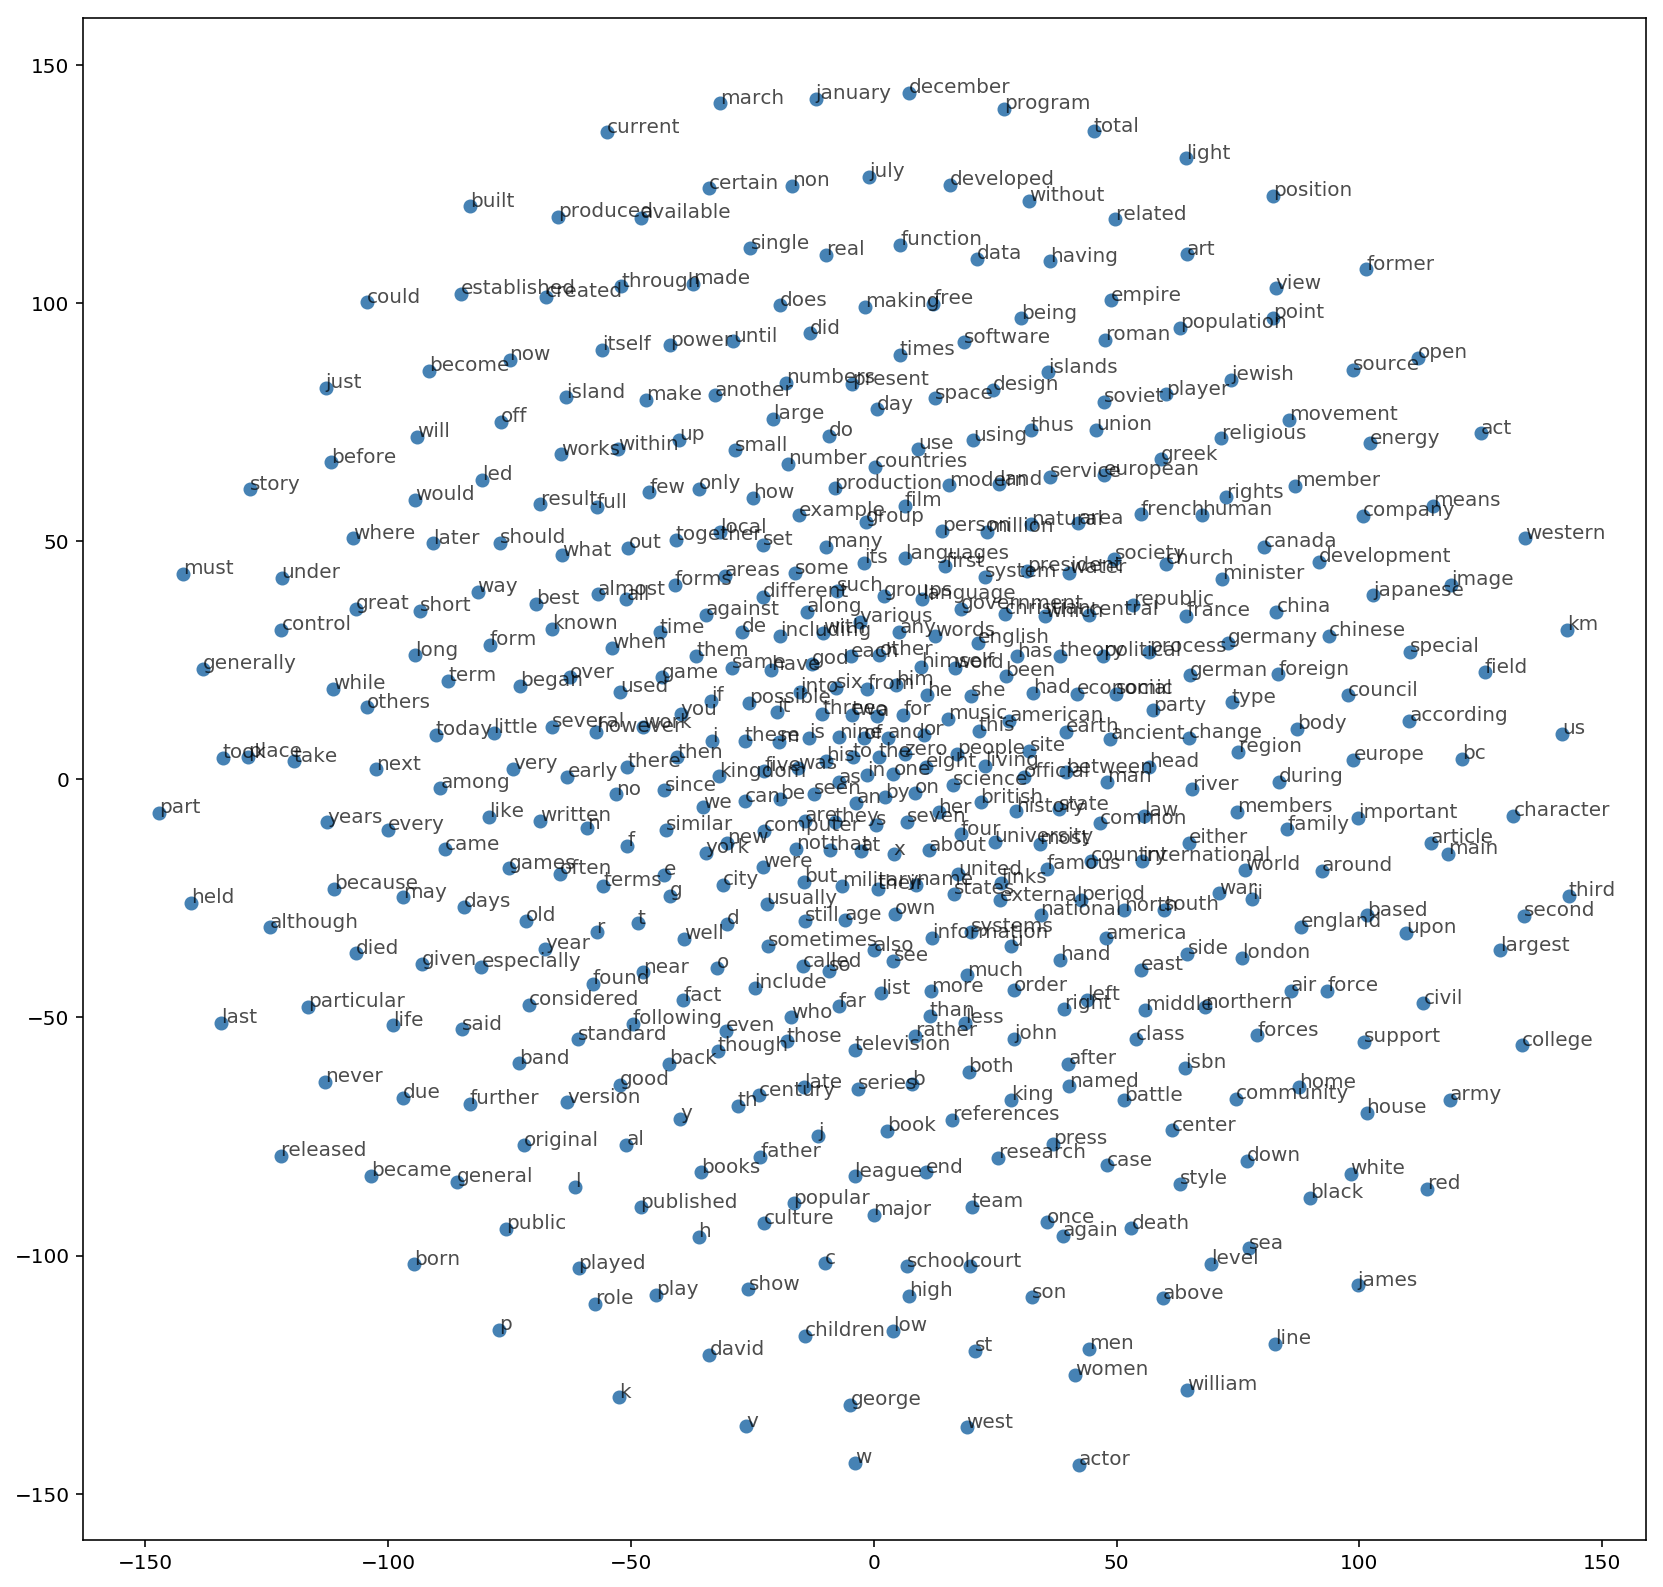

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)